In [1]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [2]:
import sys
sys.path.insert(0, r'../../../quetzal')
import pandas as pd
from quetzal.model import stepmodel, model

if manual:
    %matplotlib inline

SQLalchemy is not installed. No support for SQL output.


In [3]:
training_folder = '../../'
plot_path = training_folder + 'outputs/plot/'

In [4]:
sm = stepmodel.read_zip(training_folder + 'model/base/networks.zip')

read_hdf: 100%|████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 55.21it/s]


# Networkcaster
à faire sur un réseau propre, avant l'agrégation

In [5]:
sm.integrity_fix_sequences()

In [6]:
sm.integrity_fix_nodeset_consistency()
sm.integrity_test_all(errors='raise', verbose=False)

5927it [00:00, 15277.28it/s]
5927it [00:01, 3292.72it/s]


## rail

In [7]:
rail = sm.copy()
rail.links = rail.links.loc[rail.links['route_type'].isin(['tram', 'subway', 'rail'])]
rail.preparation_cast_network(dumb_cast=True)

nearest_link: 100%|███████████████████████████████████████████████████████████| 30220/30220 [00:00<00:00, 65838.80it/s]


## road

In [8]:
road = sm.copy()
road.links = road.links.loc[road.links['route_type'].isin(['bus'])]

In [9]:
len(sm.road_nodes), len(sm.road_links)

(5927, 14652)

In [10]:
road.preparation_cast_network(
    nearest_method='nodes',
    n_neighbors_centroid=5, 
    n_neighbors=5, 
    penalty_factor=2,
    replace_nodes=False
)

100100064:64_0: 100%|████████████████████████████████████████████████████████████████| 243/243 [00:47<00:00,  5.15it/s]


## both road and rail

In [11]:
both = road.copy()
both.links = pd.concat([road.links, rail.links]) 

In [12]:
both.analysis_lines(line_columns='all')

# to_zip

In [13]:
both.to_zip(training_folder + 'model/base/road_model.zip' )  

to_hdf(new file): 100%|████████████████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.88it/s]


could not save attribute: missing_nodes
could not save attribute: orphan_nodes
could not save attribute: missing_road_nodes
could not save attribute: networkcaster


# monitoring

In [14]:
from shapely.geometry import LineString

links = road.links
links['link_straight_length'] = links['geometry'].apply(
    lambda g: LineString([list(g.coords[0]), list(g.coords[-1])]).length
)

road.build_lines(sum_columns=['link_straight_length'])
lines = road.lines
lines['length'] = lines['geometry'].apply(lambda g: g.length)
lines['straight_length'] = lines['geometry'].apply(
    lambda g: LineString([list(g.coords[0]), list(g.coords[-1])]).length
)

lines['length_ratio'] = lines['length']/lines['link_straight_length']

Deprecated: replaced by analysis_lines


In [15]:
# summary
title = str(
    (lines[['link_straight_length', 'straight_length', 'length']].sum() / 1000).astype(int).to_dict()
)[1:-1]

Text(0.5, 1.0, "'link_straight_length': 1922, 'straight_length': 1481, 'length': 2859")

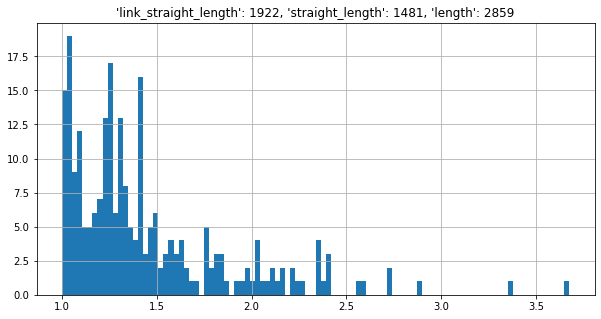

In [16]:
ax = lines['length_ratio'].hist(bins=100, figsize=[10, 5])
ax.set_title(title)

# plot

In [17]:
url = 'http://a.basemaps.cartocdn.com/light_nolabels/tileZ/tileX/tileY.png'

import matplotlib.pyplot as plt
def plot_networkcaster(raw, processed, figsize=[25, 25],url=None, *args, **kwargs):
    fig, ax_array = plt.subplots(2, 2,  figsize=figsize, tight_layout=True) 
    buffer = raw.copy()
    buffer.zones['geometry'] = buffer.zones['geometry'].apply(lambda g: g.buffer(500))

    plot = raw.plot(
        'road_nodes', markersize=0.3, color='green',
        ax=raw.plot('road_links', linewidth=0.3, color='green',
                   ax=buffer.plot('zones', alpha=0, ax=ax_array[0][0])
                  ),
        basemap_url=url,title="Road network", fontsize=36
    )
    plot = raw.plot('links', 
                                      ax=buffer.plot('zones', alpha=0, ax=ax_array[0][1]),
        basemap_url=url, title="GTFS", fontsize=36
    )
    plot = raw.plot('links', ax=raw.plot('road_links', color='green', figsize=[16, 9], linewidth=0.5,
                                      ax=buffer.plot('zones', alpha=0, ax=ax_array[1][0])),
        basemap_url=url,title="raw GTFS & road network", fontsize=36
    )
    plot = processed.plot(
        'links', 
        ax=processed.plot('road_links', color='green', figsize=[16, 9], linewidth=0.5,
                     ax=buffer.plot('zones', alpha=0, ax=ax_array[1][1])),
        basemap_url=url,title="Processed GTFS & Road Network", fontsize=36
    )
    return fig

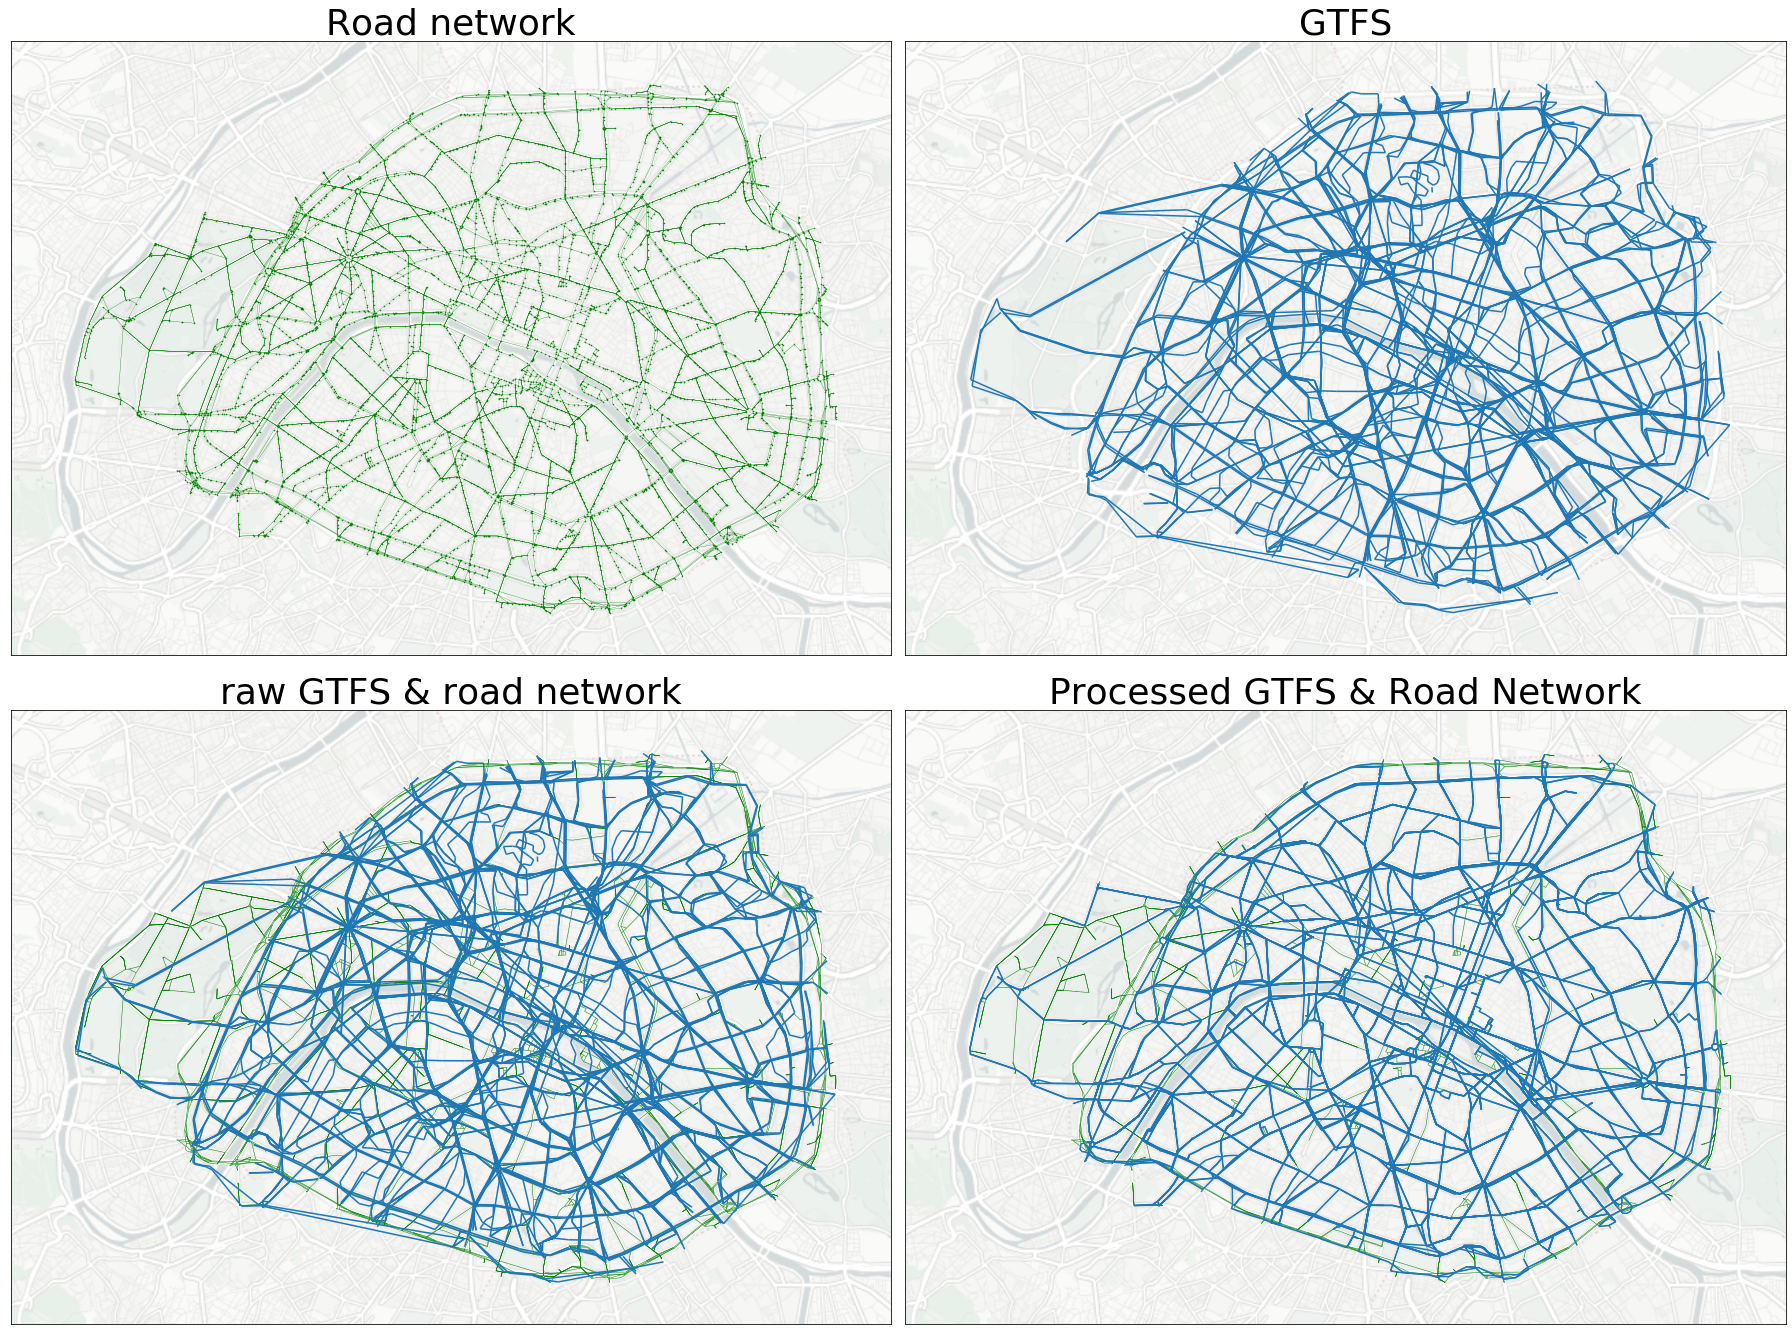

In [18]:
if manual:
    fig = plot_networkcaster(raw=sm, processed=both, url=url)